# Evaluating models

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray.plot as xplt
import cftime

In [2]:
import torch
import os, sys
dir2 = os.path.abspath('../../unet/unet')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import unet
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import pysteps

Pysteps configuration file found at: /home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/pysteps/pystepsrc



In [4]:
hi_res_data = xr.open_mfdataset("../../../../derived_data/2.2km-london/rcp85/01/pr/day/*.nc").isel(ensemble_member=0, time=slice(720))
hi_res_data.assign_coords(season=(('time'), (hi_res_data.month_number.values % 12 // 4)))
lo_res_data = xr.open_mfdataset("../../../../derived_data/coarsened-4x-2.2km-london/rcp85/01/pr/day/*.nc").isel(ensemble_member=0, time=slice(720))
lo_res_data.assign_coords(season=(('time'), (lo_res_data.month_number.values % 12 // 4)))

<xarray.Dataset>
Dimensions:                     (bnds: 2, grid_latitude: 53, grid_longitude: 53, time: 720)
Coordinates:
    ensemble_member             int32 1
  * time                        (time) object 1980-12-01 12:00:00 ... 1982-11...
  * grid_latitude               (grid_latitude) float64 -1.5 -1.48 ... -0.46
  * grid_longitude              (grid_longitude) float64 361.1 361.1 ... 362.1
    ensemble_member_id          |S27 dask.array<chunksize=(), meta=np.ndarray>
    latitude                    (grid_latitude, grid_longitude) float64 dask.array<chunksize=(53, 53), meta=np.ndarray>
    longitude                   (grid_latitude, grid_longitude) float64 dask.array<chunksize=(53, 53), meta=np.ndarray>
    month_number                (time) int32 dask.array<chunksize=(360,), meta=np.ndarray>
    year                        (time) int32 dask.array<chunksize=(360,), meta=np.ndarray>
    yyyymmdd                    (time) |S64 dask.array<chunksize=(360,), meta=np.ndarray>
    season                      (time) int32 0 0 0 0 0 0 0 0 ... 2 2 2 2 2 2 2 2
Dimensions without coordinates: bnds
Data variables:
    pr                          (time, grid_latitude, grid_longitude) float32 dask.array<chunksize=(360, 53, 53), meta=np.ndarray>
    rotated_latitude_longitude  (time) int32 -2147483647 ... -2147483647
    time_bnds                   (time, bnds) object dask.array<chunksize=(360, 2), meta=np.ndarray>
    grid_latitude_bnds          (time, grid_latitude, bnds) float64 dask.array<chunksize=(360, 53, 2), meta=np.ndarray>
    grid_longitude_bnds         (time, grid_longitude, bnds) float64 dask.array<chunksize=(360, 53, 2), meta=np.ndarray>
Attributes: (12/15)
    collection:      land-cpm
    contact:         ukcpproject@metoffice.gov.uk
    creation_date:   2019-07-30T06:13:12
    domain:          uk
    frequency:       day
    institution:     Met Office Hadley Centre (MOHC), FitzRoy Road, Exeter, D...
    ...              ...
    resolution:      2.2km
    scenario:        rcp85
    source:          UKCP18 realisation from a set of 12 convection-permittin...
    title:           UKCP18 land projections - 2.2km convection-permitting cl...
    version:         v20190731
    Conventions:     CF-1.5

In [5]:
def load_model(path):
    return torch.load(path, map_location=torch.device('cpu'))

def predict(model, lo_res_data, hi_res_data):
    test_set = TensorDataset(torch.stack([torch.tensor(lo_res_data.pr.values)], dim=1))
    test_dl = DataLoader(test_set, batch_size=64)

    pred = np.concatenate([model(batch[0]).squeeze().detach().numpy() for batch in test_dl])
    
    ds = xr.Dataset(data_vars={key: hi_res_data.data_vars[key] for key in ["time_bnds", "grid_latitude_bnds", "grid_longitude_bnds", "rotated_latitude_longitude"]}, coords=hi_res_data.coords, attrs={})
    ds['pr'] = xr.DataArray(pred, dims=["time", "grid_longitude", "grid_latitude"])
    return ds
    
#     return 

In [6]:
model_path = '../../checkpoints/3801893.bp1/model-epoch1999.pth'
model_1_preds = predict(load_model(model_path), lo_res_data, hi_res_data)

model_path = '../../checkpoints/u-net-coarsened-4x-london-pr/model-epoch200.pth'
model_2_preds = predict(load_model(model_path), lo_res_data, hi_res_data)

/home/henry/anaconda3/envs/downscaling/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


(array([494.,  78.,  55.,  38.,  20.,  18.,  11.,   3.,   0.,   3.]),
 array([-2.0040787e+01,  6.5171260e+03,  1.3054292e+04,  1.9591459e+04,
         2.6128625e+04,  3.2665793e+04,  3.9202957e+04,  4.5740125e+04,
         5.2277293e+04,  5.8814457e+04,  6.5351625e+04], dtype=float32),
 <BarContainer object of 10 artists>)

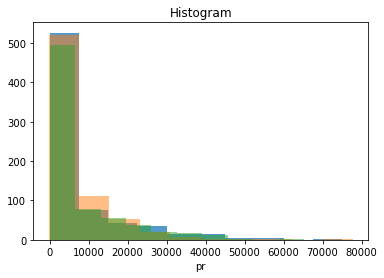

In [7]:
hi_res_data.sum(dim=["grid_longitude", "grid_latitude"]).pr.plot.hist(alpha=0.75)
model_1_preds.sum(dim=["grid_longitude", "grid_latitude"]).pr.plot.hist(alpha=0.5)
model_2_preds.sum(dim=["grid_longitude", "grid_latitude"]).pr.plot.hist(alpha=0.5)

In [8]:
cp_model_rotated_pole = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
platecarree = ccrs.PlateCarree()

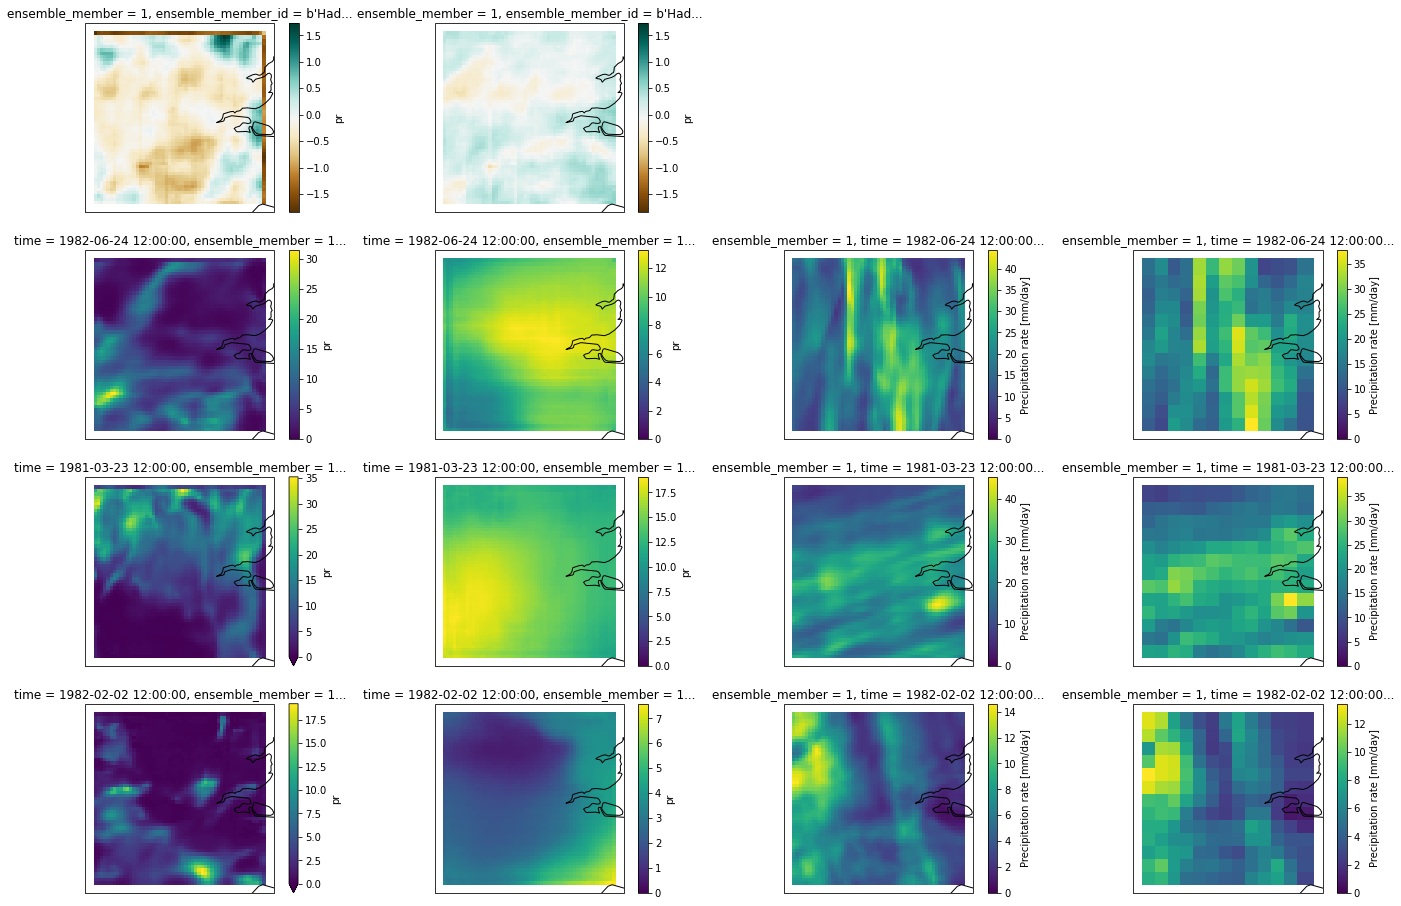

In [15]:
model_1_mean_diff = (model_1_preds.mean(dim=["time"]).pr - hi_res_data.mean(dim=["time"]).pr)
model_2_mean_diff = (model_2_preds.mean(dim=["time"]).pr - hi_res_data.mean(dim=["time"]).pr)

vmin = min(model_1_mean_diff.min().values, model_2_mean_diff.min().values)
vmax = max(model_1_mean_diff.max().values, model_2_mean_diff.max().values)

fig = plt.figure(figsize=(24, 16))
ax = fig.add_subplot(4, 4, 1, projection=cp_model_rotated_pole)
ax.coastlines()
model_1_mean_diff.plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=vmin, vmax=vmax, cmap='BrBG')
ax = fig.add_subplot(4, 4, 2, projection=cp_model_rotated_pole)
ax.coastlines()
model_2_mean_diff.plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=vmin, vmax=vmax, cmap='BrBG')

# fig = plt.figure(figsize=(24, 8))
ax = fig.add_subplot(4, 4, 5, projection=cp_model_rotated_pole)
ax.coastlines()
model_1_preds.pr.sel(time="1982-06-24").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 6, projection=cp_model_rotated_pole)
ax.coastlines()
model_2_preds.pr.sel(time="1982-06-24").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 7, projection=cp_model_rotated_pole)
ax.coastlines()
hi_res_data.pr.sel(time="1982-06-24").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 8, projection=cp_model_rotated_pole)
ax.coastlines()
lo_res_data.pr.sel(time="1982-06-24").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)

ax = fig.add_subplot(4, 4, 9, projection=cp_model_rotated_pole)
ax.coastlines()
model_1_preds.pr.sel(time="1981-03-23").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 10, projection=cp_model_rotated_pole)
ax.coastlines()
model_2_preds.pr.sel(time="1981-03-23").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 11, projection=cp_model_rotated_pole)
ax.coastlines()
hi_res_data.pr.sel(time="1981-03-23").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 12, projection=cp_model_rotated_pole)
ax.coastlines()
lo_res_data.pr.sel(time="1981-03-23").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)


ax = fig.add_subplot(4, 4, 13, projection=cp_model_rotated_pole)
ax.coastlines()
model_1_preds.pr.sel(time="1982-02-02").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 14, projection=cp_model_rotated_pole)
ax.coastlines()
model_2_preds.pr.sel(time="1982-02-02").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 15, projection=cp_model_rotated_pole)
ax.coastlines()
hi_res_data.pr.sel(time="1982-02-02").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)
ax = fig.add_subplot(4, 4, 16, projection=cp_model_rotated_pole)
ax.coastlines()
lo_res_data.pr.sel(time="1982-02-02").plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=0)

In [16]:
fig.savefig("eval-test-plots.png")

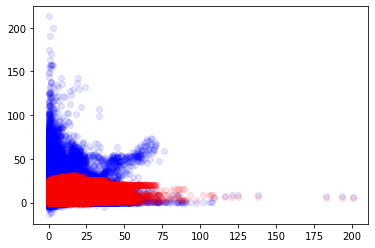

In [19]:
plt.scatter(x=hi_res_data.pr, y=model_1_preds.pr, alpha=0.1, c='b')
plt.scatter(x=hi_res_data.pr, y=model_2_preds.pr, alpha=0.1, c='r')